# Data Incubator Project Plot 2

Anjia Wang

Plot 2 mainly introduces the feature that finds out more similar papers among the reading list. It applies TF-IDF
and PCA techniques to plot all papers in graph for clustering. The result locates near the bottom of this document.

Currently it only analyzes the reading list as an example. In the future, fuzzy c means clustering and parallel computing (CPU or GPU) will be implemented to calculate the whole literature dataset. And the result will be stored in MySQL database for efficiency. Every three months or half year, the database is recalculated after adding new papers. During this period, any new paper will be determined by keywords and fuzzy clustering technique to find the most related papers.

In [1]:
import math, pandas
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

In [2]:
def loadTxt(filename):
    f = open(filename, 'r')
    lines = f.read().splitlines()
    
    data = {}
    # data[i] = {id:-1, title:'', author:[], venue:'', year:-1, abstract:'', ref:[], 'cited':0, 'dis': {}}
    # cited: how many times one is cited, how important it is.
    # dis: the shortest distance between one and all others. Currently it isn't used.
    
    newLine = True
    del(lines[0]) # remove irrelevant line, which is the total entry number.
    for v in lines:
        if (newLine):
            entry = [-1, {'id':-1, 'title':'', 'author':[], 'venue':'', 'year':-1, 'ref':[], 'abstract':'', 'cited':[], 'dis':{}}]
            newLine = False
        if (v[0:2] == '#*'):
            entry[1]['title'] = v[2:]
        elif (len(v) > 6 and v[0:6] == '#index'):
            entry[0] = int(v[6:])
            entry[1]['id'] = int(v[6:])
        elif (v[0:2] == '#@'):
            for u in v[2:].split(','):
                entry[1]['author'].append(u)
        elif (v[0:2] == '#t'):
            entry[1]['year'] = int(v[2:])
        elif (v[0:2] == '#c'):
            entry[1]['venue'] = v[2:]
        elif (v[0:2] == '#%'):
            entry[1]['ref'].append(int(v[2:]))
        elif (v[0:2] == '#!'):
            entry[1]['abstract'] = v[2:]
        else:
            if (entry[1]['abstract'] != ''): # remove
                data[entry[0]] = entry[1] 
            newLine = True

    return data

In [3]:
def stopwords(filename):
    f = open(filename, 'r')
    lines = f.read().splitlines()
    words = []
    for v in lines:
        words += v.split(',')
    return set(words)

In [4]:
def cleanData(data):
    for v in data.values():
        removed = []
        for u in v['ref']:
            if (u in data):
                data[u]['cited'].append(v['id'])
            else:
                removed.append(u)
        for u in removed:
            v['ref'].remove(u)

    return data

In [5]:
# calculate the similarities
def calcSim(data, words):
    tfidf = TfidfVectorizer(stop_words=words)
    
    docs = [(v['id'], v['abstract']) for v in data.values()]
    
    pipeline = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer())])        
    similarities = pipeline.fit_transform([v[1] for v in docs]).todense()

    pca = PCA(n_components=2).fit(similarities)
    result = pca.transform(similarities)
    plt.scatter(result[:,0], result[:,1], c='b')
    
    for i in range (len(docs)):
        plt.annotate(str(docs[i][0]), (result[i, 0], result[i, 1]))


In [6]:
# get references
def getRef(data, paper, output):
    if (output):
        print(data[paper]['title'])
    refs = {}

    for v in data[paper]['ref']:
        if (output):
            print('-------------------------------')
            print(str(v) + ': ' + data[v]['title'])
            print('Cited: ' + str(len(data[v]['cited'])))
            print('*******************************')
        refs[v] = [u for u in [w for w in data[v]['cited'] if len(data[w]['cited'])>10] if len(data[u]['cited'])>10]
        if (output):
            for u in data[v]['cited']:
                print('        ' + str(u) + ': ' + data[u]['title'])
                print('        Cited: ' + str(len(data[u]['cited'])))

    return (paper, [v for v in data[paper]['ref'] if len(data[v]['cited'])>10], refs)

In [7]:
def plot(data, refs):

    allRef = []
    for v in refs[1]:
        allRef += refs[2][v]
    allRef = list(set(allRef))
    coord1 = {}
    coord2 = {}

    r = 10*len(refs[1])+5   #radius
    n = len(refs[1]) #points to generate
    cP = [
        [r * math.cos(theta), r * math.sin(theta)]
        for theta in (math.pi*2 * i/n for i in range(n))
    ]

    r2 = r + 10*len(allRef) + 10
    n2 = len(allRef)
    cP2 = [
        [r2 * math.cos(theta), r2 * math.sin(theta)]
        for theta in (math.pi*2 * i/n2 for i in range(n2))
    ]

    for i in range (n2):
        coord2[allRef[i]] = (cP2[i][0], cP2[i][1])
    for i in range (n):
        coord1[refs[1][i]] = (cP[i][0], cP[i][1])
    
    for i in range (n):
        cP[i].append(len(data[refs[1][i]]['cited'])+0.1)
    for i in range (n2):
        cP2[i].append(len(data[allRef[i]]['cited'])+0.1)


    fig = plt.figure()
    ax_data_plot = fig.add_subplot(111)

    ax_data_plot.scatter([0], [0], color = 'r', label='1st refs')
    plt.annotate(str(refs[0]), xy=(0,0), xycoords='data', xytext=(5, 0), textcoords='offset points')

    ax_data_plot.scatter([x[0] for x in cP], [x[1] for x in cP], color='b', label='1st refs', s=[10*x[2] for x in cP], marker='o', edgecolors='none')
    ax_data_plot.scatter([x[0] for x in cP2], [x[1] for x in cP2], color='g', label='2nd refs', s=[10*x[2] for x in cP2], marker='o', edgecolors='none')

    for i in range (n):
        plt.annotate('', xy=coord1[refs[1][i]], xycoords='data', xytext=(0, 0), textcoords='data', arrowprops={'arrowstyle':'->', 'color':'gray'})
        plt.annotate(str(refs[1][i]), xy=coord1[refs[1][i]], xycoords='data', xytext=(10*np.sign(coord1[refs[1][i]][0]), 10*np.sign(coord1[refs[1][i]][1])), textcoords='offset points')

    for v in refs[1]:
        for u in refs[2][v]:
            plt.annotate('', xy=coord1[v], xycoords='data', xytext=coord2[u], textcoords='data', arrowprops={'arrowstyle': '->', 'color':'gray'})
            plt.annotate(str(u), xy=coord2[u], xycoords='data', xytext=(10*np.sign(coord2[u][0]), 10*np.sign(coord2[u][1])), textcoords='offset points')


    plt.show()

In [8]:
dataSet = loadTxt('outputacm.txt')

In [9]:
stop = stopwords('common-english-words.txt')

In [10]:
dataSet = cleanData(dataSet)

In [11]:
testID = 628180

In [12]:
refResult = getRef(dataSet, testID, False)
refGroup = []
for v in refResult[2].values():
    refGroup += v
refGroup = {refResult[0]:dataSet[refResult[0]],  **{v:dataSet[v] for v in refResult[2]}, **{v:dataSet[v] for v in refGroup}}

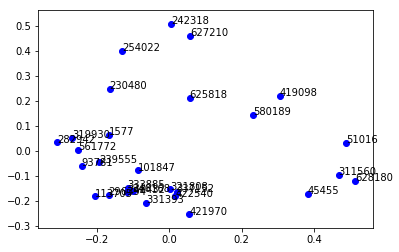

In [13]:
calcSim(refGroup, stop)

The graph is generated based on principle component analysis of abstracts. The first two are used as coordinates to plot. It shows clearly the papers around the bottom left corner are more similar and they might need more attentions to read.
The details of those papers can be obtained as plot 1.
Combine these two features, one can quickly get a larger picture of the searching topic by the generated reading list.